In [12]:
import os
import sys
sys.path.append('../Prelim_Stats')
import config
import numpy as np
import xarray as xr
import pyproj
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import probplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import multivariate_normal
from pyproj import Transformer
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

In [13]:
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from pyextremes import plot_mean_residual_life
from closest_grid_cell import select_nearest_grid_cell
from pyextremes import plot_parameter_stability
from pyextremes import plot_return_value_stability

Threshold selection : based on Mean Residual Life (https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/)

#Estimation of Mean Residual life

In [14]:
data_hr_precip= xr.open_dataset(f'{config.TARGET_DIR}/RhiresD_1971_2023.nc')
data_hr_precip= data_hr_precip.sel(time=slice('1981-01-01', '2010-12-31'))

In [15]:
 # Target location (Locarno)
target_lat = 46.1709
target_lon = 8.7995

In [16]:
data_hr_precip_locarno = select_nearest_grid_cell(data_hr_precip, target_lat, target_lon, 'RhiresD')
    
precip_series_hr = data_hr_precip_locarno['data']
lat_idx = data_hr_precip_locarno['lat_idx']
lon_idx = data_hr_precip_locarno['lon_idx']

Target: (46.1709, 8.7995)
Closest grid cell: (46.1737, 8.8048)
Distance: 0.0060 degrees
Grid indices: lat_idx=50, lon_idx=231
Variable 'RhiresD' extracted
Time series shape: (10957,)
Data range: -0.00 to 270.14


In [17]:
precip_series_hr_pd= precip_series_hr.to_pandas()

Ways of chosing a threshold : MRL (1)

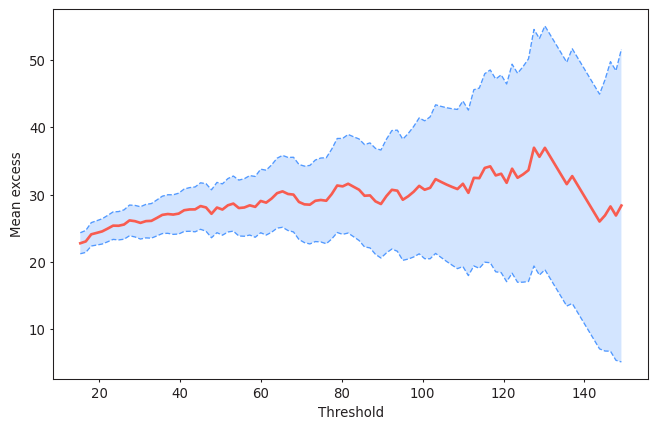

In [18]:
plot_mean_residual_life(precip_series_hr_pd)
plt.show() #MRL is the least useful as it is visually subjective

Method II : Parametric Stability 

(<Axes: ylabel='Shape, $\\xi$'>,
 <Axes: xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>)

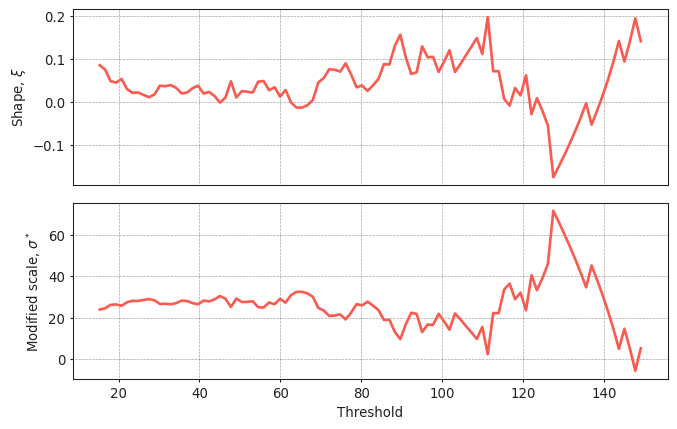

In [19]:
plot_parameter_stability(precip_series_hr_pd) #Stabilises around 60 mm as the threshold and the higher variance with increasing threshold 

Method III : extension of Method II : return value stability 

Return value stability for 10-year return level:
Return value stability for 50-year return level:
Return value stability for 100-year return level:


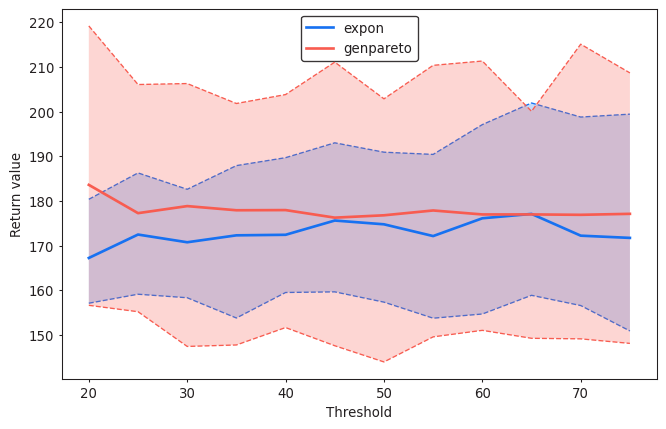

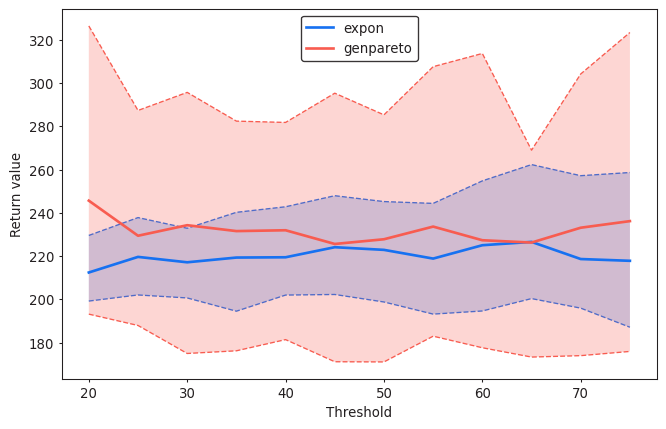

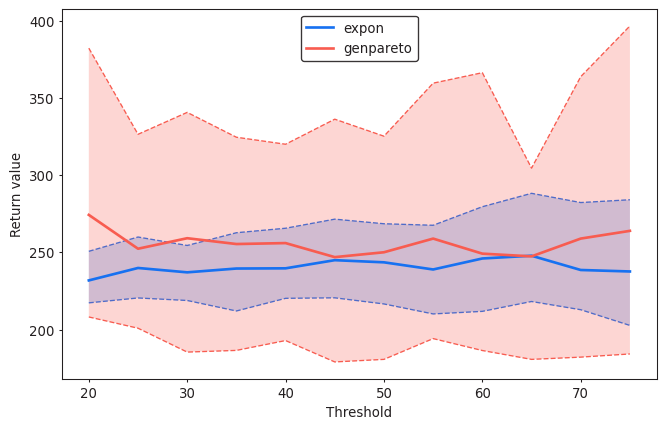

In [20]:
for i, period in enumerate([10,50,100]):
    print(f"Return value stability for {period}-year return level:")
    plot_return_value_stability(precip_series_hr_pd, 
                                return_period=period, 
                                thresholds= np.arange(20,80,5),
                                alpha=0.95,)
    

#Return value : the amount to be exceeded every 

Threshold value of around 50 mm/day was selected for precip. Based on methods 1 and II!